# Проект анализа и прогнозирования оттока клиентов сети фитнес-центров

## Цель проекта:

Провести анализ и подготовить план действий по удержанию клиентов

## Входные данные:

Набор данных, собранных из клиентских анкет, в виде csv-файлов, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

## План проекта:

### Этап 1. Получение данных

- импортируем библиотеки
- откроем файлы с данными
- изучим общую информацию данных

### Этап 2 Исследовательский анализ данных (EDA)

- посмотрим есть ли в датасете отсутствующие признаки, изучим средние значения и стандартные отклонения
- посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
- построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
- построим матрицу корреляций

### Этап 3. Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

*Для этого:*

- разобьем данные на обучающую и валидационную выборки
- обучим модель на train-выборке двумя способами:
    - *логистической регрессией*
    - *случайным лесом*
- оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

### Этап 4. Кластеризация клиентов

- cтандартизируем данные
- построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму
- обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
- посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- построим распределения признаков для кластеров. Можно ли что-то заметить по ним?
- для каждого полученного кластера посчитаем долю оттока. Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

### Этап 5. Общие выводы и базовые рекомендации по работе с клиентами

## Описание данных

Данные клиента за предыдущий до проверки факта оттока месяц:
- *'gender'* — пол;
- *'Near_Location'* — проживание или работа в районе, где находится фитнес-центр;
- *'Partner'* — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- *Promo_friends* — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- *'Phone'* — наличие контактного телефона;
- *'Age'* — возраст;
- *'Lifetime'* — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- *'Contract_period'* — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- *'Month_to_end_contract'* — срок до окончания текущего действующего абонемента (в месяцах);
- *'Group_visits'* — факт посещения групповых занятий;
- *'Avg_class_frequency_total'* — средняя частота посещений в неделю за все время с начала действия абонемента;
- *'Avg_class_frequency_current_month'* — средняя частота посещений в неделю за предыдущий месяц;
- *'Avg_additional_charges_total'* — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- *'Churn'* — факт оттока в текущем месяце.

## Этап 1. Получение данных

In [3]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [4]:
#загрузим данные
try: 
    data = pd.read_csv('/datasets/gym_churn.csv') #путь к файлу в общем хранилище
except: 
    data = pd.read_csv('C:/Users/Admin/Downloads/gym_churn.csv') #путь к файлу на локальной машине

In [5]:
data.head() #посмотрим на несколько строк данных

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
data.shape # посмотрим на размер датасета

(4000, 14)

In [7]:
#посмотрим общую информацию
print('Общая информация')
data.info()
print('====================================')
print('Дубликатов в таблице:', data.duplicated().sum())
print('====================================')
print('Пропусков в таблице:')
print(data.isna().sum())
print('====================================')
print('Количество уникальных значений:')
print(data.nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000

In [8]:
# приведем названия столбцов к нижнему реистру
data.columns = data.columns.str.lower()

In [9]:
data.head(2) # проверим

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0


**Итог ознакомления с данными:**
   * тип данных колонок соответствует
   * пропусков нет
   * дубликатов нет
   * заменили регистр столбцов на нижний

## Этап 2 Исследовательский анализ данных (EDA)

Посмотрим на статистические данные

In [10]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Что видим из статистических данных?:

- разделение по гендеру почти 50 на 50;
- больше 80% клиентов живут либо работают по близости к фитнес-центру;
- около половины клиентов оформились по партнерской программе;
- около 30% клиентов воспользовались акцией "приведи друга";
- 90% клиентов оставили свой телефон при указании контактов в анкете;
- длительность текущего действующего абонемента в среднем составляет чуть более 4-х месяцев;
- около 40% клиентов сходили на групповые занятия;
- средний возраст клиентов - 29 лет
- средняя частота посещений в неделю за все время с начала действия абонемента - 1,87 дней в неделю
- средняя частота посещений в неделю за предыдущий месяц - 1,76 дней в неделю
- 26% оттока

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [11]:
data.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

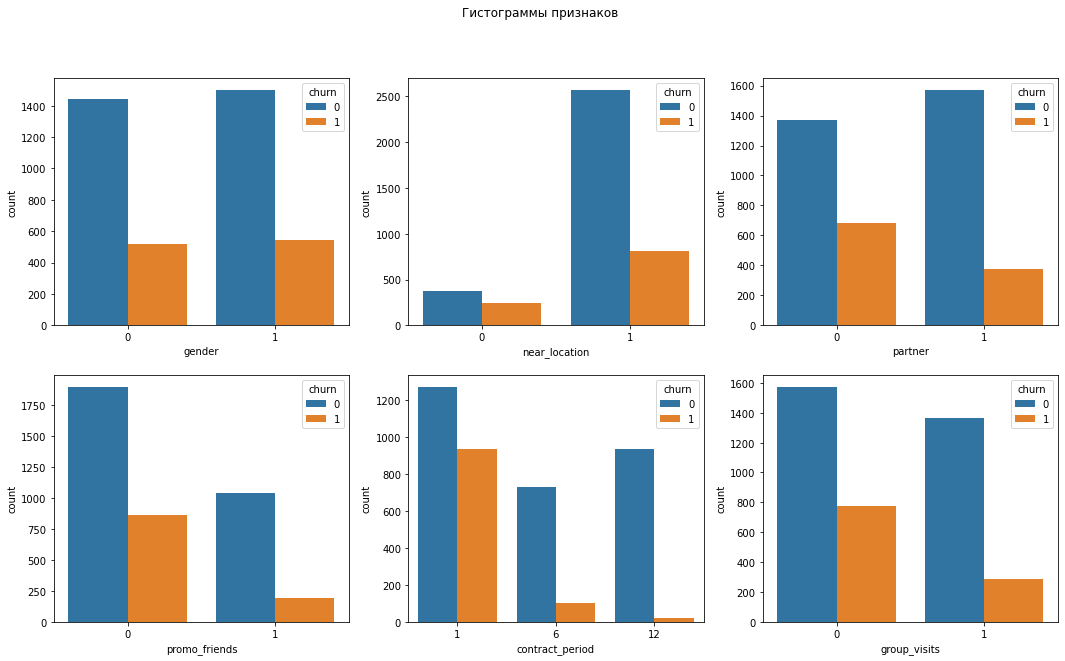

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Гистограммы признаков')

sns.countplot(ax=axes[0, 0], data=data, x='gender', hue='churn')
sns.countplot(ax=axes[0, 1], data=data, x='near_location', hue='churn')
sns.countplot(ax=axes[0, 2], data=data, x='partner', hue='churn')
sns.countplot(ax=axes[1, 0], data=data, x='promo_friends', hue='churn')
sns.countplot(ax=axes[1, 1], data=data, x='contract_period', hue='churn')
sns.countplot(ax=axes[1, 2], data=data, x='group_visits', hue='churn')
plt.show()

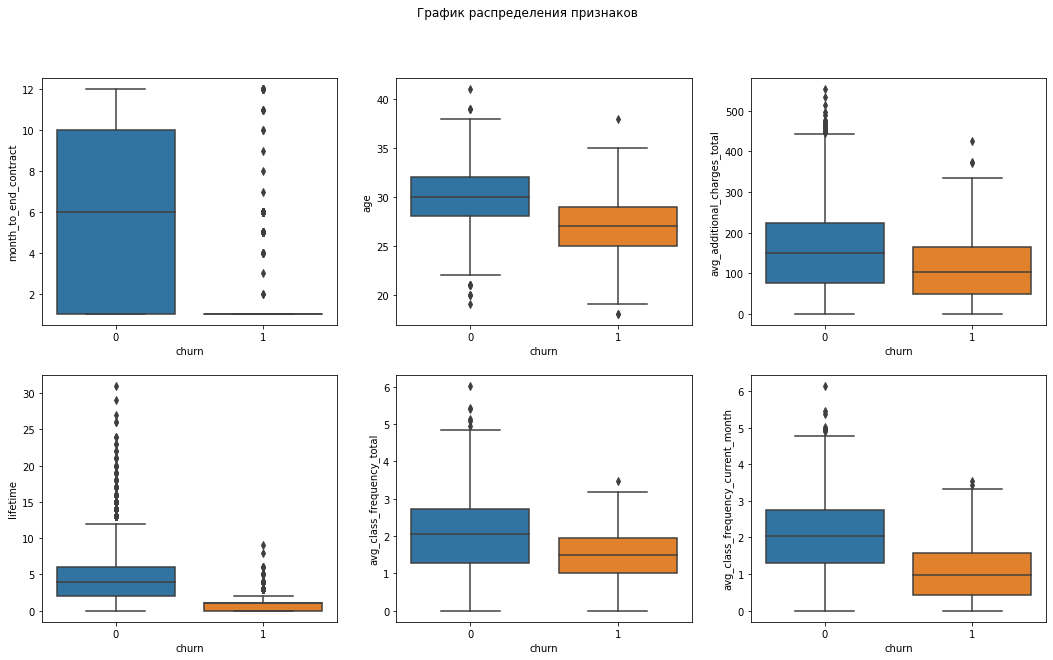

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('График распределения признаков')

sns.boxplot(ax=axes[0, 0], data=data, x = 'churn', y='month_to_end_contract')
sns.boxplot(ax=axes[0, 1], data=data, x = 'churn', y='age')
sns.boxplot(ax=axes[0, 2], data=data, x = 'churn', y='avg_additional_charges_total')
sns.boxplot(ax=axes[1, 0], data=data, x = 'churn', y='lifetime')
sns.boxplot(ax=axes[1, 1], data=data, x = 'churn', y='avg_class_frequency_total')
sns.boxplot(ax=axes[1, 2], data=data, x = 'churn', y='avg_class_frequency_current_month')
plt.show()

Предварительные выводы:

- мужчины как и женщины уходят практически поровну;
- клиенты, находящиеся рядом с фитнес-центром тоже активно уходят;
- клиентов, которые уходят, больше всего с абонементом на месяц;
- суммарная выручка от доп.услуг в среднем у активных клинтов составляет около 160 у.е., у уходящих - 115 у.е.;
- групповыми занятиями пользуются около половины "активистов" и около 25% "уходящих";
- уходящие чуть моложе активных

Построим матрицу корреляций

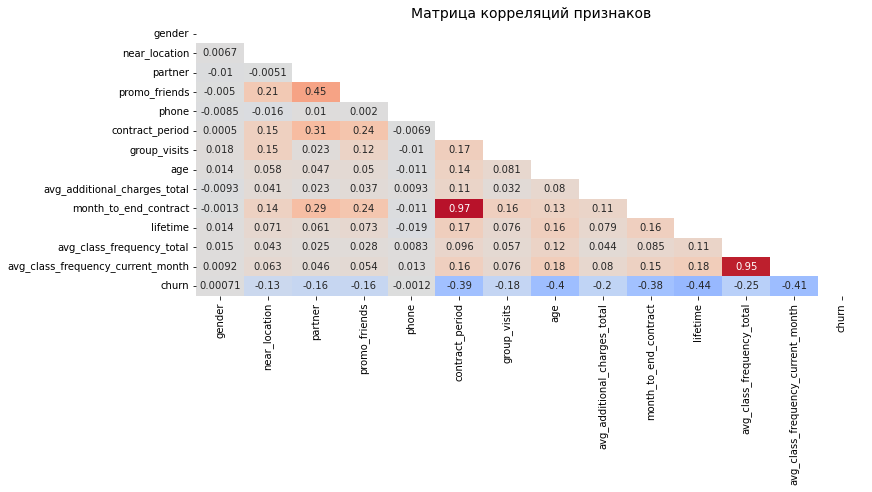

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
matrix = np.triu(data.corr())
sns.heatmap(data.corr()
            , annot = True
            , mask=matrix
            , fmt='.2g'
            , vmin=-1
            , vmax=1
            , center= 0
            , cmap= 'coolwarm'
            , cbar=False)
plt.title('Матрица корреляций признаков', fontsize = 14)
plt.show()

Сильно коррелирующие между собой признаки:
- contract_period = month_to_end_contract;
- avg_class_frequency_current_month = avg_class_frequency_total

Один из признаков мультиколлинеарной пары нужно удалить, чтобы они не мешали в обучении моделей.

## Этап 3. Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

**Разобьем данные на обучающую и валидационную выборку**

In [15]:
# создадим новый датафейм дропнув мультиколлинеарные признаки
data_corr_del = data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

In [16]:
# разделим наши данные на признаки (X) и целевую переменную (y)
X = data_corr_del.drop('churn', axis=1)
y = data_corr_del['churn']

In [17]:
# Разобьем данные на обучающую и валидационную выборки функцией train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [18]:
# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train) 
X_test_st =  scaler.transform(X_test)

**Обучим модель на *train*-выборке двумя способами:**

*Логистической регрессией*

In [19]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state = 0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

*Случайным лесом*

In [20]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

**Оценим метрики *accuracy, precision* и *recall* для обеих моделей на валидационной выборке**

- accuracy - доля правильных ответов
- precision - точность
- recall - полнота
- F1 - баланс между *precision* и *recall*

In [21]:
# создадим функцию для отображения всех метрик
def all_metric(y_true, y_pred, y_proba, title):
    print(title)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print( )

In [22]:
# отобразим метрики двух моделей
all_metric(y_test, lr_predictions, lr_probabilities, 'Метрики для модели логистической регрессии:')
all_metric(y_test, rf_predictions, rf_probabilities, 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
Accuracy: 0.92
Precision: 0.85
Recall: 0.84
F1: 0.84

Метрики для модели случайного леса:
Accuracy: 0.91
Precision: 0.85
Recall: 0.77
F1: 0.81



Сравнивая метрики обоих моделей, можно сказать, что лучше всего себя показала **логистическая регрессия**.

## Этап 4. Кластеризация клиентов

In [23]:
# стандартизируем данные, отложив в сторону столбец с оттоком 
data_sс = scaler.fit_transform(data.drop(columns = ['churn']))
# построим матрицу расстояний
linked = linkage(data_sс, method = 'ward')

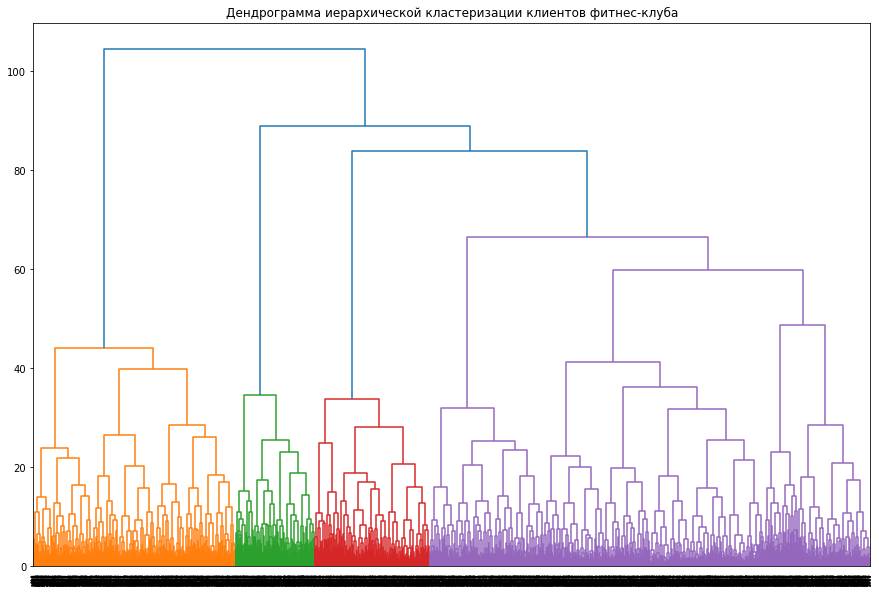

In [24]:
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентов фитнес-клуба')
plt.show() 

На основании графика можно выделить 4 кластера

**Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов**

In [25]:
# зададим модель k_means с числом кластеров 5 и зафиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# спрогнозируем кластеры для наблюдений
labels = km.fit_predict(data_sс)

# сохраним метки кластера в поле нашего датасета
data['cluster_km'] = labels

Количество кластеров (в нашем случае 5) выбрали исходя из требования в задании.

Посмотрим на средние значения признаков для кластеров

In [26]:
data.groupby(['cluster_km']).mean().T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Минимальный отток клиентов в кластерах №0 и №4:
- мужчин и женщин - 50 на 50;
- средний возраст - 30 лет;
- половина клиентов ходят на групповые занятия;
- в кластере №0 средняя длительность контракта у клиентов - 11 месяцев и почти 80% клиентов привлечены по партнерской программе - данный кластер это "клиенты-партнеры"
- самый высокий показатель посещаемости за неделю за весь период и за последний месяц - 2 и более дней в неделю.

В кластере №1 26 % клиентов - отток. Клиенты данного кластера не предоставили номера телефонов для обратной связи.

В кластере №2 44 % клиентов - отток. По клиентам данного кластера нет информации о отдаленности места жительства или работы от фитнес-центра.

В кластере №3 51% клиентов - отток. Самый низкий показатель посещаемости за неделю - около одного дня в неделю.

**Построим распределения признаков для кластеров**

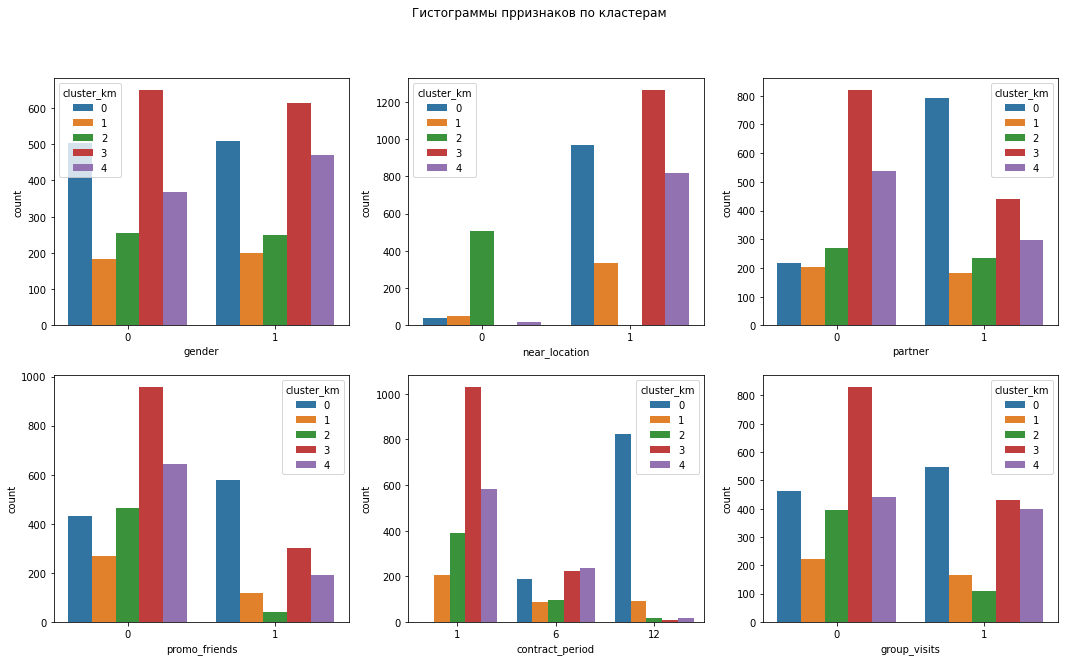

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Гистограммы прризнаков по кластерам')

sns.countplot(ax=axes[0, 0], data=data, x='gender', hue='cluster_km')
sns.countplot(ax=axes[0, 1], data=data, x='near_location', hue='cluster_km')
sns.countplot(ax=axes[0, 2], data=data, x='partner', hue='cluster_km')
sns.countplot(ax=axes[1, 0], data=data, x='promo_friends', hue='cluster_km')
sns.countplot(ax=axes[1, 1], data=data, x='contract_period', hue='cluster_km')
sns.countplot(ax=axes[1, 2], data=data, x='group_visits', hue='cluster_km')
plt.show()

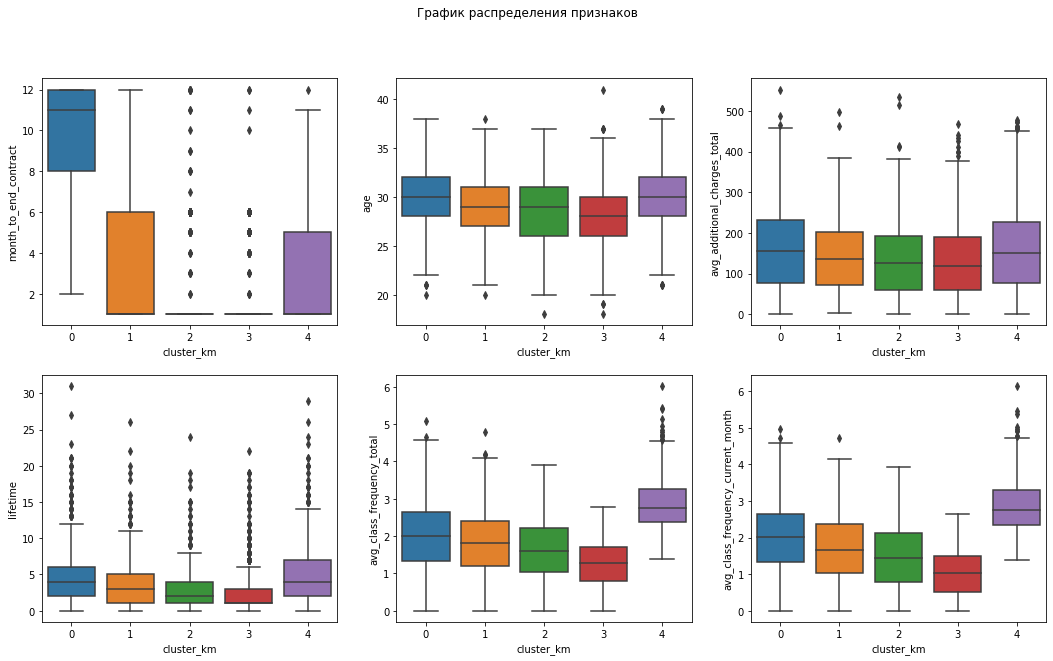

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('График распределения признаков')

sns.boxplot(ax=axes[0, 0], data=data, x = 'cluster_km', y='month_to_end_contract')
sns.boxplot(ax=axes[0, 1], data=data, x = 'cluster_km', y='age')
sns.boxplot(ax=axes[0, 2], data=data, x = 'cluster_km', y='avg_additional_charges_total')
sns.boxplot(ax=axes[1, 0], data=data, x = 'cluster_km', y='lifetime')
sns.boxplot(ax=axes[1, 1], data=data, x = 'cluster_km', y='avg_class_frequency_total')
sns.boxplot(ax=axes[1, 2], data=data, x = 'cluster_km', y='avg_class_frequency_current_month')
plt.show()

Из графиков распределения видно, что наилучшие показатели у кластеров №0 и №4

**Для каждого полученного кластера посчитаем долю оттока**

In [29]:
data.groupby('cluster_km').agg({'churn':'mean'})

,churn
cluster_km,
0,0.027723
1,0.267532
2,0.443564
3,0.514263
4,0.068019


Надежным кластером можно считать **№0**, у него доля оттока составляет 2%.

Перспективным кластером можно считать **№4**, процент оттока - 6%.

Склонные к оттоку кластеры:
   - №3 - 51%;
   - №2 - 44%;
   - №1 - 26%

## Этап 5. Общие выводы и базовые рекомендации по работе с клиентами

**Характеристики клиентов**

Опишем клиента **"лояльного"** кластера №0:
- средний возраст - 30 лет;
- пол не важен;
- живет или работает рядом с фитнес-центром;
- заинтересован групповыми занятиями (54% клиентов);
- сотрудник компании-партнёра клуба (78% клиентов);
- воспользовался акцией "приведи друга" (57% клиентов);
- средняя длительность абонемента - 11 месяцев;
- тратит около 160 у.е. в месяц на доп. услуги;
- более 4-х месяцев пользуется услугами фитнес-центра;
- 2 раза в неделю посещает фитнес-центр;
- срок до окончания текущего абонемента - 10 месяцев.

Опишем клиента **"перспективного"** кластера №4:
- средний возраст - 30 лет;
- пол не важен;
- живет или работает рядом с фитнес-центром;
- заинтересован групповыми занятиями (около 47% клиентов);
- не является сотрудником компании-партнёра и не пользовался акцией "приведи друга" (около 70% клиентов)
- средняя длительность абонемента - 2-3 месяца;
- тратит около 161 у.е. в месяц на доп. услуги;
- около 5-ти месяцев пользуется услугами фитнес-центра;
- 2-3 раза в неделю посещает фитнес-центр;
- срок до окончания текущего абонемента - 2-3 месяца.

**Предположительные факторы оттока клиентов "ненадежных" кластеров:**
- небольшой период длительности абонемента - 1-3 месяца;
- низкая заинтересованность групповыми занятиями;
- низкая частота посещаемости - 1 раз в неделю.

**Рекомендации по работе с клиентами:**

- Предложение приобретения новым клиентам абонементов с длительным периодом, от 6 месяцев и более с привлекательной ценой и скидками.
- Проведение и реклама новых партнерских программ, расширение сотрудничества с компаниями.
- Проведение промо-акций групповых занятий, привлечение известных спортсменов на мастер-классы.
- Мониторинг посещаемости. Клиентам, которые посещают клуб 2 и более раз в неделю в долгосрочном периоде, предлагать бонусные тренировки, подарки, скидки на следующие абонементы.

